# Proyek Klasifikasi Gambar: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
- **Nama:** Naufal Nur Fahriza
- **Email:** naufalnurfahriza@gmail.com
- **ID Dicoding:** NurFahriza

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalnurfahriza","key":"ec6f7ab7dabebc9fd0600384aa1880de"}'}

In [4]:
!pip install -q kaggle

In [5]:
# Setup credential kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download dataset DermNet
!kaggle datasets download -d vencerlanz09/agricultural-pests-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
License(s): copyright-authors


In [7]:
# Unzip dataset
!unzip -q agricultural-pests-image-dataset.zip -d pests_data

In [9]:
# Verifikasi dataset
print("Daftar folder:")
print(os.listdir("pests_data"))
print("\nJumlah gambar per kategori:")
for folder in os.listdir("pests_data"):
    folder_path = os.path.join("pests_data", folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} gambar")

Daftar folder:
['beetle', 'catterpillar', 'ants', 'snail', 'slug', 'earwig', 'earthworms', 'weevil', 'moth', 'bees', 'wasp', 'grasshopper']

Jumlah gambar per kategori:
beetle: 416 gambar
catterpillar: 434 gambar
ants: 499 gambar
snail: 500 gambar
slug: 391 gambar
earwig: 466 gambar
earthworms: 323 gambar
weevil: 485 gambar
moth: 497 gambar
bees: 500 gambar
wasp: 498 gambar
grasshopper: 485 gambar


### Data Preprocessing

#### Split Dataset

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'pests_data/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

print("\nDistribusi data awal:")
print(df.groupby(['labels']).size())


Distribusi data awal:
labels
ants            499
bees            500
beetle          416
catterpillar    434
earthworms      323
earwig          466
grasshopper     485
moth            497
slug            391
snail           500
wasp            498
weevil          485
dtype: int64


In [11]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split ke train dan test (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [13]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('\ntrain size:', len(df_tr))
print('test size :', len(df_te))


train size: 4395
test size : 1099


In [14]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('\nDistribusi setelah split:')
print(df_all.groupby(['set', 'labels']).size())


Distribusi setelah split:
set    labels      
test   ants            100
       bees            100
       beetle           83
       catterpillar     87
       earthworms       65
       earwig           93
       grasshopper      97
       moth             99
       slug             78
       snail           100
       wasp            100
       weevil           97
train  ants            399
       bees            400
       beetle          333
       catterpillar    347
       earthworms      258
       earwig          373
       grasshopper     388
       moth            398
       slug            313
       snail           400
       wasp            398
       weevil          388
dtype: int64


In [15]:
# Buat struktur folder baru
dataset_path = "pests_dataset_final/"
os.makedirs(dataset_path, exist_ok=True)

In [16]:
# Salin gambar ke folder baru sesuai set dan label
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']
    label = row['labels']
    subset = row['set']

    dest_folder = os.path.join(dataset_path, subset, label)
    os.makedirs(dest_folder, exist_ok=True)

    file_name = os.path.basename(file_path)
    dest_path = os.path.join(dest_folder, file_name)

    if not os.path.exists(dest_path):
        shutil.copy2(file_path, dest_path)

  0%|          | 0/5494 [00:00<?, ?it/s]

### Image Data Generator

## Modelling

In [17]:
# Define training and test directories
TRAIN_DIR = "pests_dataset_final/train/"
TEST_DIR = "pests_dataset_final/test/"

class_names = os.listdir(TRAIN_DIR)

print("📊 Jumlah gambar per kelas:")
print("\nTraining Set:")
for cls in class_names:
    cls_path = os.path.join(TRAIN_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

print("\nTest Set:")
for cls in class_names:
    cls_path = os.path.join(TEST_DIR, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images}")

📊 Jumlah gambar per kelas:

Training Set:
  beetle: 333
  catterpillar: 347
  ants: 399
  snail: 400
  slug: 313
  earwig: 373
  earthworms: 258
  weevil: 388
  moth: 398
  bees: 400
  wasp: 398
  grasshopper: 388

Test Set:
  beetle: 83
  catterpillar: 87
  ants: 100
  snail: 100
  slug: 78
  earwig: 93
  earthworms: 65
  weevil: 97
  moth: 99
  bees: 100
  wasp: 100
  grasshopper: 97


In [18]:
# Buat objek ImageDataGenerator yang menormalkan gambar dan menyertakan validation split
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.85, 1.15],
    validation_split=0.2
)

# Generator untuk data test
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training set
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk validation set
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 3522 images belonging to 12 classes.
Found 873 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.


In [19]:
# Define Transfer Learning Model with Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    decay_rate = 0.9
    decay_steps = 1000
    epoch_decay = epoch // (decay_steps // (train_generator.samples // train_generator.batch_size))
    return initial_lr * (decay_rate ** epoch_decay)

# Define the model architecture
def create_model():
    # Load MobileNetV2 as base model
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=None
    )

    # Freeze the base model
    base_model.trainable = False

    # Build custom head
    model = Sequential([
      base_model,
      Dropout(0.5),  # Tingkatkan dropout
      Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer='l2'),
      GlobalAveragePooling2D(),
      Dense(256, activation='relu', kernel_regularizer='l2'),
      Dropout(0.3),
      Dense(len(class_names), activation='softmax')
    ])

    return model

# Create model
model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,638,188 (10.06 MB)

 Trainable params: 380,204 (1.45 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',  # Using modern .keras format
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    LearningRateScheduler(lr_schedule),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [21]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Initial learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

#Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Load the best model (using modern .keras format)
model = tf.keras.models.load_model('best_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4792 - loss: 2.5803 - precision: 0.7887 - recall: 0.3057
Epoch 1: val_accuracy improved from -inf to 0.79496, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 629ms/step - accuracy: 0.4804 - loss: 2.5750 - precision: 0.7889 - recall: 0.3074 - val_accuracy: 0.7950 - val_loss: 1.1998 - val_precision: 0.8757 - val_recall: 0.7423 - learning_rate: 0.0010
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8088 - loss: 1.1726 - precision: 0.8729 - recall: 0.7522
Epoch 2: val_accuracy did not improve from 0.79496
111/111 ━━━━━━━━━━━━━━━━━━━━ 62s 509ms/step - accuracy: 0.8087 - loss: 1.1728 - precision: 0.8729 - recall: 0.7521 - val_accuracy: 0.7743 - val_loss: 1.1734 - val_precision: 0.8411 - val_recall: 0.7274 - learning_rate: 0.0010
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8225 - loss: 1.0161 - precision: 0.8884 - recall: 0.7804
Epoch 3: val_accuracy did not improv

## Evaluasi dan Visualisasi

In [22]:
# Evaluasi di test set
print("\n⚙️ Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"\n📊 Test Metrics:")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Loss: {test_loss:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


⚙️ Evaluating on test set...
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8214 - loss: 0.7942 - precision: 0.8725 - recall: 0.7951

📊 Test Metrics:
Accuracy: 84.26%
Loss: 0.7369
Precision: 0.8902
Recall: 0.8189


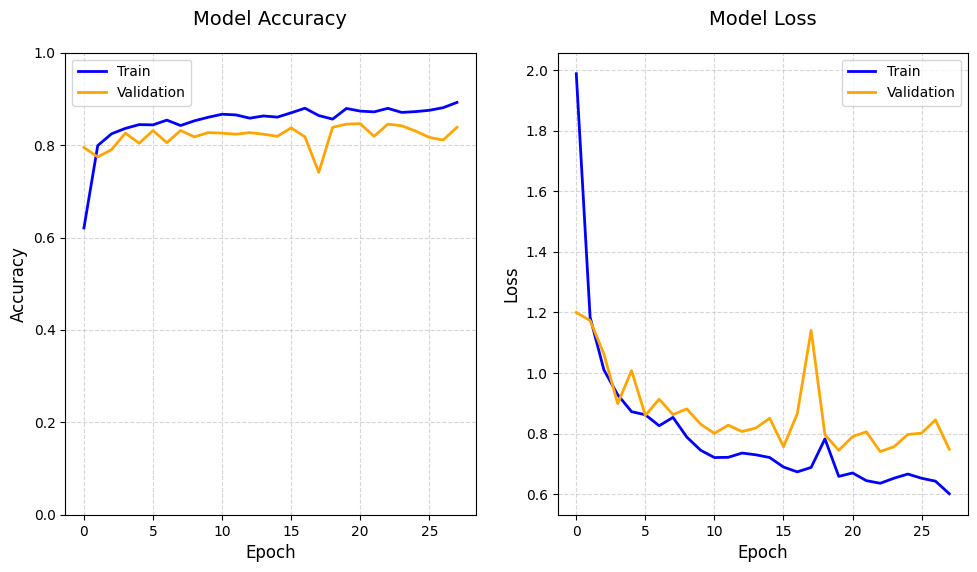

In [23]:
# Plot grafik akurasi & loss
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)
plt.title('Model Accuracy', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', color='orange', linewidth=2)
plt.title('Model Loss', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


In [24]:
# Prediksi data test
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification Report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

📝 Classification Report:
              precision    recall  f1-score   support

        ants     0.9118    0.9300    0.9208       100
        bees     0.8990    0.8900    0.8945       100
      beetle     0.5882    0.6024    0.5952        83
catterpillar     0.8615    0.6437    0.7368        87
  earthworms     0.8000    0.6769    0.7333        65
      earwig     0.8750    0.6022    0.7134        93
 grasshopper     0.8600    0.8866    0.8731        97
        moth     0.9688    0.9394    0.9538        99
        slug     0.6273    0.8846    0.7340        78
       snail     0.9604    0.9700    0.9652       100
        wasp     0.8649    0.9600    0.9100       100
      weevil     0.8739    1.0000    0.9327        97

    accuracy                         0.8426      1099
   macro avg     0.8409    0.8321    0.8302      1099
weighted avg     0.8497    0.8426    0.8402      1099



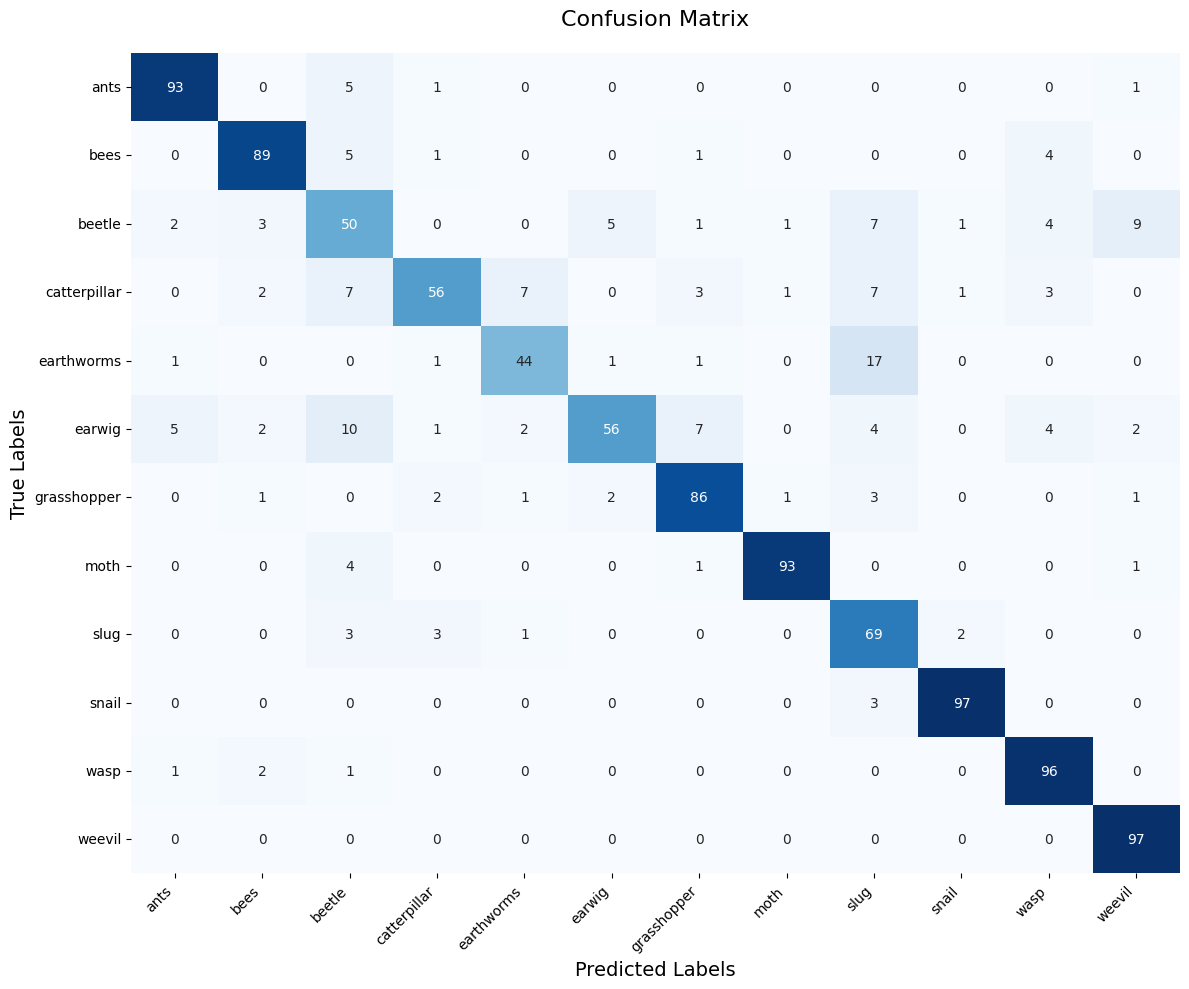

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

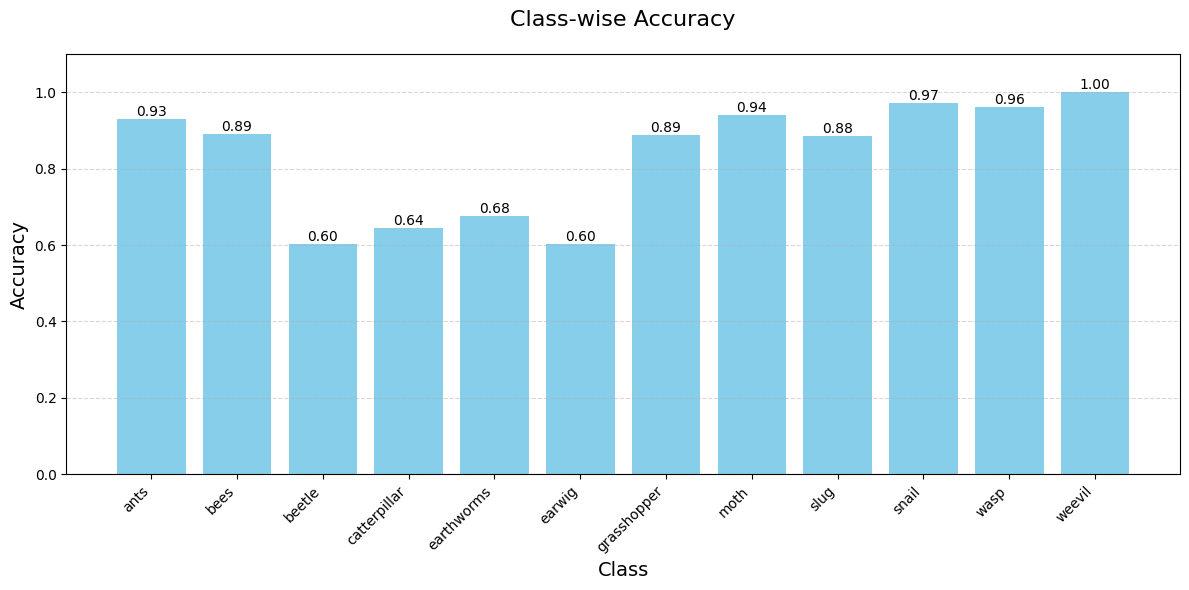

In [26]:
# Class-wise Accuracy
correct = np.zeros(len(class_names))
total = np.zeros(len(class_names))

for i in range(len(y_true)):
    class_idx = y_true[i]
    total[class_idx] += 1
    if y_true[i] == y_pred[i]:
        correct[class_idx] += 1

class_accuracy = correct / total

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy', fontsize=16, pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Add accuracy values on top of bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## Konversi Model

In [27]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [28]:
# Model Export Function
def export_model(model, class_names):
    # Create directories
    os.makedirs('saved_model', exist_ok=True)
    os.makedirs('tflite', exist_ok=True)
    os.makedirs('tfjs_model', exist_ok=True)

    # 1. Save in SavedModel format (for TF Serving/Cloud)
    tf.saved_model.save(model, 'saved_model/my_model')  # Corrected this line

    # 2. Convert to TFLite (for mobile devices)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('tflite/model.tflite', 'wb') as f:
        f.write(tflite_model)

    # Save labels for TFLite
    with open('tflite/labels.txt', 'w') as f:
        f.write('\n'.join(class_names))

    # 3. Convert to TFJS (for web)
    try:
        import tensorflowjs as tfjs
        tfjs.converters.save_keras_model(model, 'tfjs_model')
    except ImportError:
        print("⚠️ tensorflowjs not installed. Run: pip install tensorflowjs")

    print("✅ Model exported in all formats")

# Export the model
print("\n🛠️ Exporting model...")
export_model(model, class_names)


🛠️ Exporting model...
Saved artifact at '/tmp/tmps8q4vwsv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138260508209232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508212112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508210384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508210576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508211152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508198096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508200784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138259318816848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508212880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260508210192: TensorSpec(shape=(), dtype=tf.resource, na

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model exported in all formats


In [29]:
#Generate requirements.txt
print("\n📦 Generating requirements.txt...")
!pip freeze > requirements.txt

print("\n✅ All done! Model exported in all required formats.")


📦 Generating requirements.txt...

✅ All done! Model exported in all required formats.


In [30]:
!zip -r submission.zip tfjs_model/ tflite/ saved_model/ requirements.txt

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 9%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tflite/ (stored 0%)
  adding: tflite/labels.txt (deflated 23%)
  adding: tflite/model.tflite (deflated 8%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 77%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 92%)
  adding: requirements.txt (deflated 57%)


## Inference (Optional)